In [2]:
import numpy as np
import pandas as pd

import os
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import statannot

from sklearn.utils import resample
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer

from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter

from lifelines.utils import concordance_index
from xgboost import XGBRegressor,XGBClassifier
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

from keras.models import Sequential
from keras.layers import Dense, Dropout

from scipy.stats import mannwhitneyu,wilcoxon,shapiro, levene, ttest_ind,f_oneway,kruskal


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, normalize, StandardScaler
from sklearn.metrics import roc_curve, auc, accuracy_score, make_scorer,precision_recall_curve
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.svm import SVC
from abc import ABC, abstractmethod

import shap

import warnings
warnings.filterwarnings("ignore")


# Prepare Data

In [3]:
metab_df=pd.read_csv('../data/Using/metab.csv',index_col=0)
sample_df=pd.read_csv('../data/Using/sample.csv',index_col=0)
lipid_df=pd.read_csv('../data/Using/lipid.csv',index_col=0)
# sample_df=chemical_sample_df
# sample_df.set_index("Sample Name",inplace=True)
metab_cluster=pd.read_csv('../data/metab/cluster_result.csv',index_col=0)
lipid_cluster=pd.read_csv('../data/lipid/cluster_result.csv',index_col=0)
metab_num=metab_df.shape[1]
lipid_num=lipid_df.shape[1]

sample_df=sample_df.rename(columns={'TMN':'TNM'})


In [4]:
metab_cluster

,nmf_3_clusters,kmeans_3_clusters,nmf_2_clusters,kmeans_2_clusters,batch
1452,1,1,1,1,1
8339,1,1,1,1,1
5608,1,1,1,1,1
8232,3,3,2,2,1
8775,2,3,2,2,1
...,...,...,...,...,...
140143-T,1,2,1,1,2
190040-T,1,2,1,1,2
190161-T,3,2,2,1,2
200288-T,3,2,2,2,2


In [5]:
sample_df['metab_cluster']=metab_cluster['kmeans_2_clusters'].reindex(sample_df.index)
sample_df['lipid_cluster']=lipid_cluster['kmeans_2_clusters'].reindex(sample_df.index)

In [6]:
sample_df=sample_df.dropna(axis=0,how='any',subset=['lipid_cluster','metab_cluster'])

In [7]:
sample_df

,Unnamed: 0,hospital_id,Name,batch,os,oss,type,TNM,主要分型,次要分型,...,克隆,MT2结构,pTNMs,生存时间,状态,生存时间分组,ascl1,codex_new,metab_cluster,lipid_cluster
Sample Name,,,,,,,,,,,,,,,,,,,,,
1520,0.0,305980,张文东,1.0,140.67,1.0,Y,I,A,Y,...,2.0,high,I,140.666667,1.0,LTS,27.387988,N,2.0,2.0
2423,1.0,337236,章立球,1.0,90.33,1.0,N,I,A,NaN,...,1.0,low,I,90.333333,1.0,LTS,74.232005,A,1.0,2.0
3334,2.0,379551,高秀芬,1.0,80.97,1.0,Y,III,A,NaN,...,1.0,low,III,80.966667,1.0,LTS,71.903618,A,2.0,2.0
1277,3.0,297125,朱桂林,1.0,86.43,0.0,P,II,P,NaN,...,NaN,high,II,86.433333,0.0,LTS,NaN,NaN,2.0,2.0
4931,4.0,472789,刘经江,1.0,58.73,0.0,N,I,A,N,...,2.0,high,I,58.733333,0.0,LTS,69.037432,A,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210011-T,100.0,2032993,周保珍,2.0,0.33,0.0,N,II,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0
200095-T,102.0,643779,胡俊,2.0,10.30,1.0,P,II,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,STS,NaN,NaN,1.0,2.0
200097-T,103.0,646890,徐文德,2.0,9.47,0.0,A,II,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,2.0


<Axes: xlabel='metab_cluster'>

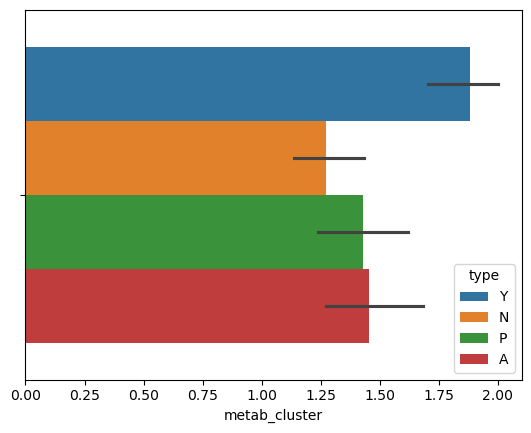

In [8]:
sns.barplot(data=sample_df,x='metab_cluster',hue='type',dodge=True)

<Axes: xlabel='metab_cluster', ylabel='count'>

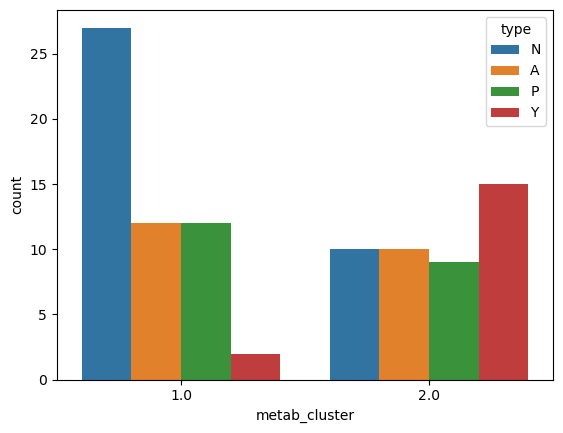

In [9]:
sns.countplot(data=sample_df,x='metab_cluster',hue='type',dodge=True)

<Axes: xlabel='metab_cluster', ylabel='count'>

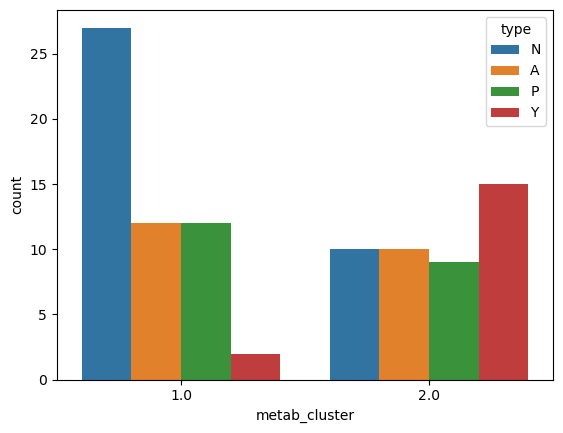

In [10]:
sns.countplot(data=sample_df,x='metab_cluster',hue='type',dodge=True)

In [11]:
import matplotlib
matplotlib.matplotlib_fname()

'/home/suh/anaconda3/envs/MetabSubtype/lib/python3.9/site-packages/matplotlib/mpl-data/matplotlibrc'

In [12]:
zhfont1 = matplotlib.font_manager.FontProperties(fname="SimHei.ttf") 
zhfont1

In [13]:
matplotlib.get_cachedir()

'/home/suh/.cache/matplotlib'

In [14]:
# a=sorted([f.name for f in matplotlib.font_manager.fontManager.ttflist])

# for i in a:
#     print(i)

In [15]:
sample_df.columns

Index(['Unnamed: 0', 'hospital_id', 'Name', 'batch', 'os', 'oss', 'type',
       'TNM', '主要分型', '次要分型', 'RNAseq分型', '尝试分型', '转录组分型', 'rfs', 'rfss',
       'CODEX主要亚型', '克隆', 'MT2结构', 'pTNMs', '生存时间', '状态', '生存时间分组', 'ascl1',
       'codex_new', 'metab_cluster', 'lipid_cluster'],
      dtype='object')

In [16]:
candidate_columns=['CODEX主要亚型','克隆','MT2结构','TNM']

<Figure size 640x480 with 0 Axes>

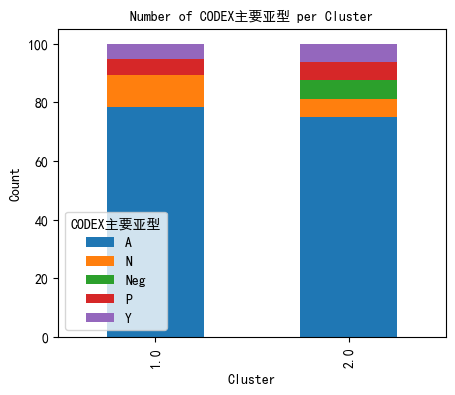

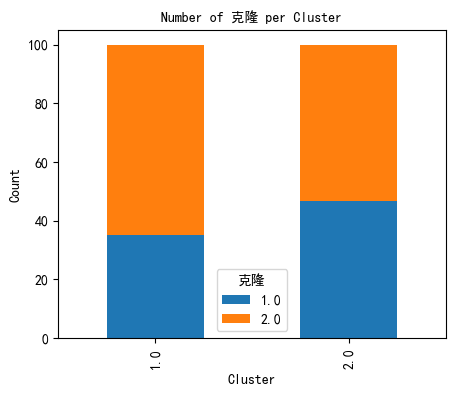

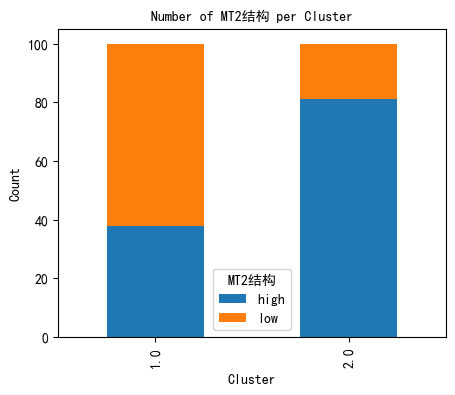

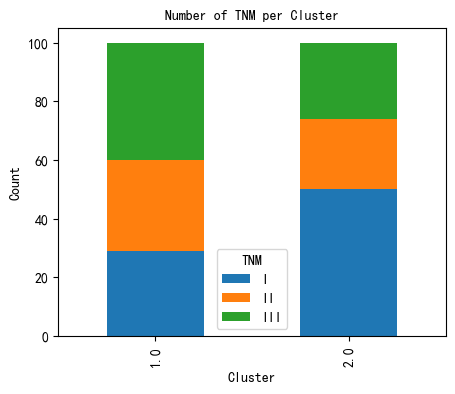

In [17]:
plt.rcParams["font.sans-serif"]=["SimHei"] #设置字体
plt.rcParams["axes.unicode_minus"]= False #设置字体
stack_column=''
for stack_column in candidate_columns:
    
# Group by 'cluster' and 'male', then count the occurrences
    grouped = sample_df.groupby(['metab_cluster', stack_column]).size().unstack(fill_value=0)
    grouped
    grouped_percentage = grouped.div(grouped.sum(axis=1), axis=0) * 100

    plt.set_cmap('Set1')
    # Plot the stacked bar chart
    # plt.figure(figsize=(2, 4))
    fig,ax=plt.subplots()
    grouped_percentage.plot(kind='bar', stacked=True,width=0.5,ax=ax,figsize=(5,4))
    
    # Customize the plot
    plt.title(f'Number of {stack_column} per Cluster',fontproperties=zhfont1)
    plt.xlabel('Cluster',fontproperties=zhfont1)
    plt.ylabel('Count',fontproperties=zhfont1)
    # plt.legend(title='Male', labels=['Female', 'Male'])

    # Show the plot
    # plt.show()

In [18]:
plt.figure()
plt.bar()

TypeError: bar() missing 2 required positional arguments: 'x' and 'height'

<Figure size 640x480 with 0 Axes>

<Axes: xlabel='lipid_cluster', ylabel='count'>

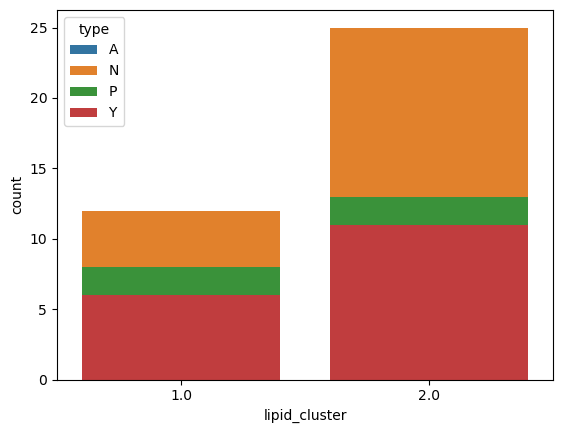

In [ ]:
sns.countplot(data=sample_df,x='lipid_cluster',hue='type',dodge=False)

# Test

In [ ]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
import requests

In [ ]:
url='https://huggingface.co'
try:
    response=requests.options(url)
    if response.ok:   # alternatively you can use response.status_code == 200
        print("Success - API is accessible.")
    else:
        print(f"Failure - API is accessible but sth is not right. Response codde : {response.status_code}")
except (requests.exceptions.HTTPError, requests.exceptions.ConnectionError) as e:
    print(f"Failure - Unable to establish connection: {e}.")
except Exception as e:
    print(f"Failure - Unknown error occurred: {e}.")

Failure - Unable to establish connection: HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: / (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fed207d7130>: Failed to establish a new connection: [Errno 110] Connection timed out')).
